# Contexto

Nesse projeto, foi explorada uma base de dados que contém a quantidade de refeições (almoço e jantar) realizadas no Restaurante Universitário da Universidade Federal do Ceará, nos anos de 2016 a 2020.

Para trabalhar, foi seguida a metodologia OSEMN (Obtain, Scrub, Explore, Model, iNterpret).

# Etapa 0 - Importação de bibliotecas e funções auxiliares

In [61]:
import os
import pickle
import warnings
import researchpy

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from scipy.stats import skew, kurtosis
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [67]:
def estatisticas(df):
    """
    Calcula algumas estatísticas descritivas sobre as variáveis numéricas de uma base de dados.
    É apenas uma incrementação do método describe() da biblioteca pandas.
    """
    
    d = df.describe(include='all')
    d.loc['skewness'] = skew(df)
    d.loc['kurtosis'] = kurtosis(df)
    
    return d

def metricas_regressao(ytrue, ypred, model):
    model_name = type(model).__name__
    
    result = pd.DataFrame(index = [], columns = ['Model', 'MAE', 'MAPE', 'RMSE'])
    
    result.loc[0, :] = [
        model_name,
        mean_absolute_error(ytrue, ypred),
        mean_absolute_percentage_error(ytrue, ypred),
        np.sqrt( mean_squared_error(ytrue, ypred) )
    ] 
    
    return result

# Etapa 1 - Obtain/Obtenção

Nesse caso em específico, a obtenção é simples, pois basta carregar a base de dados já fornecida na competição. Em contextos reais, é comum precisar realizar *web scraping*, que consiste em uma raspagem/coleta dos dados brutos diretamente de algum site. ou outra fonte

In [4]:
# Pegando o caminho absoluto dos dados
ROOT_DIR = os.getcwd()
DATA_DIR = ROOT_DIR + '\data\data_ru.csv'

df = pd.read_csv(DATA_DIR, sep = ';')

In [5]:
# Visão geral da base de dados
df.head()

,date,lunch,dinner
0,2016-01-04,364,294
1,2016-01-05,489,363
2,2016-01-06,522,401
3,2016-01-07,514,349
4,2016-01-08,409,218


# Etapa 2 - Scrub/Limpeza

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1095 non-null   object
 1   lunch   1095 non-null   int64 
 2   dinner  1095 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 25.8+ KB


Para a análise de séries temporais, é mais adequado que a data esteja representada no tipo de dados datetime. Também podemos fazer a data ser o índice da base em vez de uma coluna.

In [7]:
df = df.set_index( 'date', drop = True )
df.index = pd.to_datetime(df.index)

# verificando o dataset após a alteração
df.head()

,lunch,dinner
date,,
2016-01-04,364,294
2016-01-05,489,363
2016-01-06,522,401
2016-01-07,514,349
2016-01-08,409,218


In [8]:
# checando por registros duplicados
df.duplicated().sum()

201

In [9]:
# checando por dados faltantes
df.isnull().sum()

lunch     0
dinner    0
dtype: int64

# Etapa 3 - Explore/Exploração
Na etapa de exploração, são realizadas verificações estatísticas sobre os dados para que haja a formulação de hipóteses sobre eles. Estamos lidando com uma base de pequeno porte, já bem preparada, então a análise se torna bem mais simples.

## 3.1. Análise descritiva

In [10]:
#fazendo uma cópia da base original para realizar alterações
df1 = df.copy()

In [11]:
#criando uma nova variável para representar o total de refeições em um dia
df1['total_refeicoes'] = df1['lunch'] + df1['dinner']

In [12]:
#Ambas variáveis são numéricas, então checamos pela distribuição.
features = df1.columns

estatisticas(df1[features])

,lunch,dinner,total_refeicoes
count,1095.000000,1095.000000,1095.000000
mean,519.748858,308.515982,828.264840
std,312.016585,226.023003,534.150505
min,0.000000,0.000000,0.000000
25%,175.500000,0.000000,176.500000
50%,646.000000,387.000000,1046.000000
75%,781.000000,503.000000,1281.000000
max,1033.000000,714.000000,1720.000000
skewness,-0.432858,-0.342741,-0.396149
kurtosis,-1.333381,-1.485497,-1.436612


Através das estatísticas _skewness_ (assimetria) e _kurtosis_ (curtose) podemos chegar às seguintes conclusões:

**Sobre assimetria**:
- Ambas variáveis apresentam uma assimetria ***negativa***, ou seja, os dados estão mais concentrados ***acima*** da média.

**Sobre curtose**:
- Ambas as variáveis apresentam um valor de curtose **menor que 3**, ou seja, a curva da distribuição é mais "achatada". Isso significa que os dados estão bem distribuídos.

## 3.2. Hipóteses

Agora, criamos algumas hipóteses em relação aos dados para tentar validá-las.

**Hipótese 1.** Uma grande parte dos estudantes universitários voltam para suas cidades de origem na sexta-feira, então, na sexta-feira são realizadas MENOS refeições.

**Hipótese 2.** Alguns estudantes não chegam exatamente na segunda-feira, então são realizadas MENOS refeições, mas com uma diferença menor do que na sexta-feira.

**Hipótese 3.** Nos meses imediatamente anteriores às férias, são realizadas MENOS refeições.

**Hipótese 4.** O total de refeições aumentou ao passar dos anos.

In [13]:
#criando novas variáveis para facilitar a análise

#ano
df1['year'] = df1.index.year

#mês
df1['month'] = df1.index.month

#dia do mês 
df1['day'] = df1.index.day

#dia da semana. Da documentação do python, sobre a função weekday: 
"""
Return the day of the week as an integer, where Monday is 0 and Sunday is 6.
"""

df1['weekday'] = df1.index.weekday

dias_da_semana = {
    0: 'Segunda-feira',
    1: 'Terça-feira',
    2: 'Quarta-feira',
    3: 'Quinta-feira',
    4: 'Sexta-feira',
    5: 'Sábado',
    6: 'Domingo'
}

meses = {
    1: 'Janeiro',
    2: 'Fevereiro',
    3: 'Março',
    4: 'Abril',
    5: 'Maio',
    6: 'Junho',
    7: 'Julho',
    8: 'Agosto',
    9: 'Setembro',
    10: 'Outubro',
    11: 'Novembro',
    12: 'Dezembro'
}

In [14]:
df1.head()

,lunch,dinner,total_refeicoes,year,month,day,weekday
date,,,,,,,
2016-01-04,364,294,658,2016,1,4,0
2016-01-05,489,363,852,2016,1,5,1
2016-01-06,522,401,923,2016,1,6,2
2016-01-07,514,349,863,2016,1,7,3
2016-01-08,409,218,627,2016,1,8,4


**Hipótese 1.** Na sexta-feira são realizadas MENOS refeições.

**Hipótese 2.** Na segunda-feira são realizadas MENOS refeições.

In [15]:
#média de refeições por dia
mean_by_weekday = df1.groupby('weekday').mean()[['lunch', 'dinner', 'total_refeicoes']]
mean_by_weekday.rename(dias_da_semana, axis=0, inplace=True)

mean_by_weekday

,lunch,dinner,total_refeicoes
weekday,,,
Segunda-feira,495.642202,331.486239,827.128440
Terça-feira,583.289593,348.393665,931.683258
Quarta-feira,566.515982,336.301370,902.817352
Quinta-feira,532.246575,312.305936,844.552511
Sexta-feira,419.903670,213.399083,633.302752


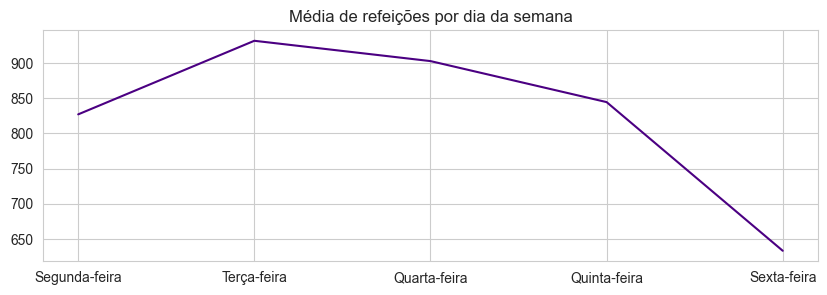

In [16]:
#visualizando a informação 
plt.figure(figsize = (10, 3))

sns.lineplot(mean_by_weekday['total_refeicoes'], color='indigo').set(xlabel=None,
                                                                     ylabel=None)
plt.title('Média de refeições por dia da semana')

plt.show()

Como podemos ver, em média, na sexta-feira realmente são feitas menos refeições, então a hipótese 1 é **verdadeira.**

Também podemos ver que, em média, na segunda-feira são realizadas menos refeições, mas essa diferença é bem pequena. Assim, a hipótese 2 também é **verdadeira.**

Além disso, chegamos a outras observações interessantes: 

- Na segunda, se comparada aos outros dias da semana (fora a sexta), a diferença da quantidade de refeições no almoço é bem maior que a diferença de refeições no jantar. Isso pode se dar ao fato de que há muitos estudantes que chegam de suas cidades de origem na segunda, mas não a tempo do almoço.

- Na sexta, são feitas muito menos refeições no jantar do que no almoço, quase metade. Isso pode se dar ao fato de que alguns estudantes têm aula durante o dia, e vão embora apenas à tarde ou à noite.

**Hipótese 3.** Nos meses imediatamente anteriores às férias, são realizadas MENOS refeições.

In [17]:
#média de refeições por mês
mean_by_month = df1.groupby('month').mean()[['lunch', 'dinner', 'total_refeicoes']]
mean_by_month.rename(meses, axis=0, inplace=True)

#porcentagem que cada mês representa em relação ao total da média de refeições no ano
mean_by_month.loc[:, 'porcentagem'] = mean_by_month.loc[:, 'total_refeicoes'] / mean_by_month.sum()['total_refeicoes']
mean_by_month['porcentagem'] = mean_by_month['porcentagem'].map(lambda x: '{:,.2%}'.format(x))

mean_by_month

,lunch,dinner,total_refeicoes,porcentagem
month,,,,
Janeiro,197.757009,71.158879,268.915888,2.66%
Fevereiro,306.378947,127.789474,434.168421,4.30%
Março,528.567568,321.576577,850.144144,8.42%
Abril,684.833333,424.488095,1109.321429,10.98%
Maio,701.175824,441.714286,1142.890110,11.31%
Junho,665.823529,411.176471,1077.000000,10.66%
Julho,254.448276,106.367816,360.816092,3.57%
Agosto,622.021978,367.527473,989.549451,9.80%
Setembro,746.500000,489.642857,1236.142857,12.24%


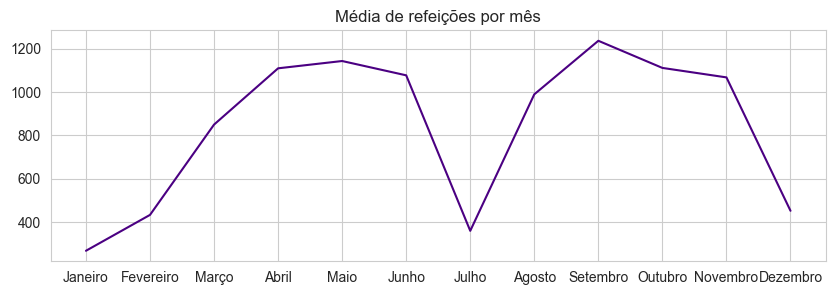

In [18]:
#visualizando a informação 
plt.figure(figsize = (10, 3))

sns.lineplot(mean_by_month['total_refeicoes'], color='indigo').set(xlabel=None,
                                                                   ylabel=None)
plt.title('Média de refeições por mês')

plt.show()

As férias geralmente iniciam nos meses de julho e dezembro, então o esperado na hipótese era que houvesse menos refeições nos meses de junho e outubro, porém observamos que isso não acontece. Sendo assim, a hipótese 3 é FALSA.

Porém, também chegamos a informações interessantes:
- Nas férias (janeiro, julho e dezembro), realmente verificamos que há menos refeições, então constatamos que, para essa informação, a base não tem inconsistência.
- No primeiro mês de aula do semestre (geralmente março e agosto), são realizadas menos refeições.

**Hipótese 4.** O total de refeições aumentou ao passar dos anos.

In [19]:
#total de refeições por ano
total_by_year = df1.groupby('year').sum()[['lunch', 'dinner', 'total_refeicoes']]

total_by_year

,lunch,dinner,total_refeicoes
year,,,
2016,127250,79182,206432
2017,137066,82175,219241
2018,134594,77932,212526
2019,150765,89338,240103
2020,19450,9198,28648


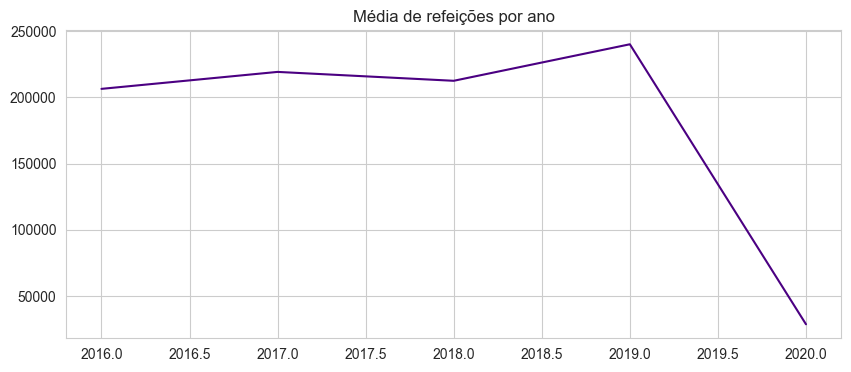

In [20]:
#visualizando a informação 
plt.figure(figsize = (10, 4))

sns.lineplot(total_by_year['total_refeicoes'], color='indigo').set(xlabel=None,
                                                                  ylabel=None)
plt.title('Média de refeições por ano')

plt.show()

Podemos ver que há uma queda brusca na quantidade de refeições no ano de 2020. Foi a época em que houve a paralisação das aulas presenciais devido à Covid, então o esperado é que apenas haja dados até o mês de março. Podemos verificar a tendência sem considerar o ano de 2020.

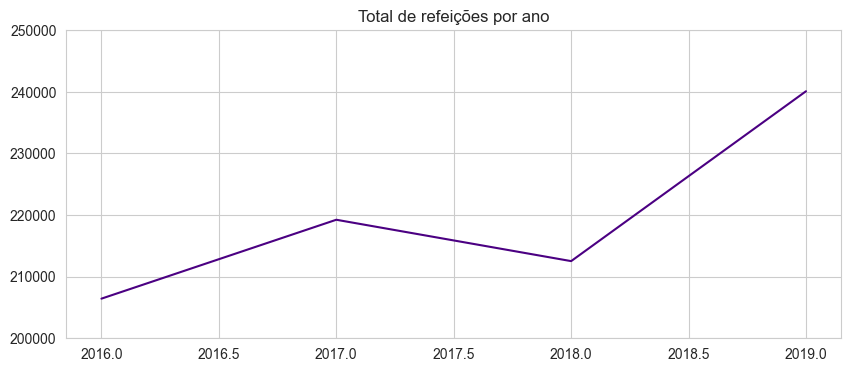

In [21]:
plt.figure(figsize = (10, 4))

sns.lineplot(total_by_year[total_by_year.index < 2020]['total_refeicoes'],
             color='indigo').set(xlabel=None,
                                 ylabel=None, 
                                 ylim = [200000, 250000])

plt.title('Total de refeições por ano')

plt.show()

O que podemos observar é que não há uma grande diferença de um ano para outro, exceto em um aumento que houve a partir do ano de 2018.

In [22]:
# verificando os meses em que há registros
df1[ df1['year'] == 2020 ]['month'].value_counts().rename(meses)

Março        22
Janeiro      20
Fevereiro    20
Name: month, dtype: int64

Como suposto, há dados apenas até março.

# Etapa 4 - Model/Modelagem

Para prosseguir com a análise, decidi adotar uma única coluna para ser a variável alvo, que corresponde ao total de refeições no dia.

In [23]:
df2 = df1.copy()
df2 = df2.drop(['lunch', 'dinner'], axis = 1)

## 4.1. Lag Features

Uma estratégia para modelagem de séries temporais é a criação de _time lag features_, que correspondem a um atraso na variável alvo em relação ao tempo. Isso nos permite estudar a autocorrelação entre os dados, ou seja, o quanto o dado de um determinado período de tempo depende de um anterior. Por exemplo, "o quanto as vendas de hoje dependem da quantidade de vendas de ontem".

Uma questão a ser avaliada é quantas lag features criar. Para isso, usaremos a função plot_acf para verificar o quanto os dados estão relacionados com as n possíveis lag criadas.

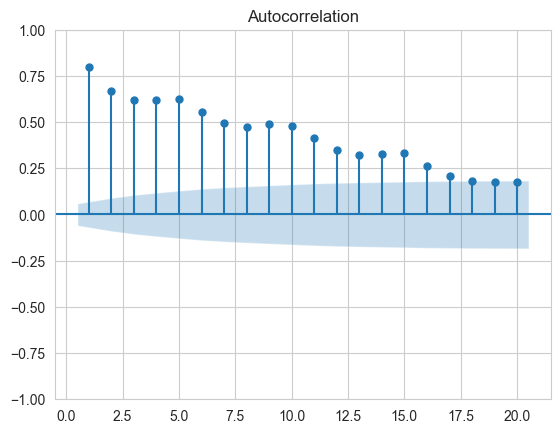

In [24]:
plot_acf(df2['total_refeicoes'], lags = 20, zero = False)

plt.show()

O que podemos observar é que até a partir da lag 5, temos uma queda na correlação. Sendo assim, criaremos 5 lags.

In [25]:
# Criação das lags
df2['lag_1'] = df2['total_refeicoes'].shift(1) 
df2['lag_2'] = df2['total_refeicoes'].shift(2)
df2['lag_3'] = df2['total_refeicoes'].shift(3)
df2['lag_4'] = df2['total_refeicoes'].shift(4)
df2['lag_5'] = df2['total_refeicoes'].shift(5)

# verificando o resultado
df2.head()

,total_refeicoes,year,month,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,,,,
2016-01-04,658,2016,1,4,0,NaN,NaN,NaN,NaN,NaN
2016-01-05,852,2016,1,5,1,658.0,NaN,NaN,NaN,NaN
2016-01-06,923,2016,1,6,2,852.0,658.0,NaN,NaN,NaN
2016-01-07,863,2016,1,7,3,923.0,852.0,658.0,NaN,NaN
2016-01-08,627,2016,1,8,4,863.0,923.0,852.0,658.0,NaN


## 4.2. Window features

Outra estratégia é a criação de Window Features, que também nos ajudam a verificar uma dependência temporal entre os dados. Porém, diferente das lag features, verificamos em relação a um intervalo de tempo, e não pontualmente. Existem algumas possibilidades para essas features, mas aqui irei utilizar a média móvel.

In [26]:
df2['moving_avg'] = df2['total_refeicoes'].rolling(5).mean()

## 4.3. Modelos de Machine Learning

Na análise de séries temporais, a separação dos dados entre treino e teste não pode ser feita como nos problemas comuns de previsão. Não é aconselhado que simplesmente sejam escolhidos dados aleatórios entre a base inteira de dados, pois estaríamos misturando dados passados com dados futuros e isso prejudica a análise. Em vez disso, devemos separar com base no tempo.

Para este problema, decidi separar os dados considerando o limite do ano de 2019.

In [27]:
train = df2.loc[ df2.index.year < 2019 ]

val = df2.loc[ df2.index.year >= 2019 ]

X_train = train.drop(['total_refeicoes'], axis = 1)
y_train = train['total_refeicoes']

X_test = val.drop(['total_refeicoes'], axis = 1)
y_test = val['total_refeicoes']

Testando as perfomances dos modelos selecionados

In [57]:
X_train = X_train.fillna(0)

In [78]:
lr = LinearRegression()
xgb = XGBRegressor()

lr.fit(X_train, y_train)
xgb.fit(X_train, y_train)

y_pred_lr = pd.Series( lr.predict(X_test), index = y_test.index )
y_pred_xgb= pd.Series( xgb.predict(X_test), index = y_test.index )

In [80]:
metricas_lr = metricas_regressao(y_pred_lr, y_test, lr)
metricas_xgb = metricas_regressao(y_pred_xgb, y_test, xgb)

m = metricas_lr.append(metricas_xgb)
m

,Model,MAE,MAPE,RMSE
0,LinearRegression,47.917755,0.258708,72.490818
0,XGBRegressor,111.833093,0.241049,186.76723


Comparando os resultados dos modelos com os dados reais

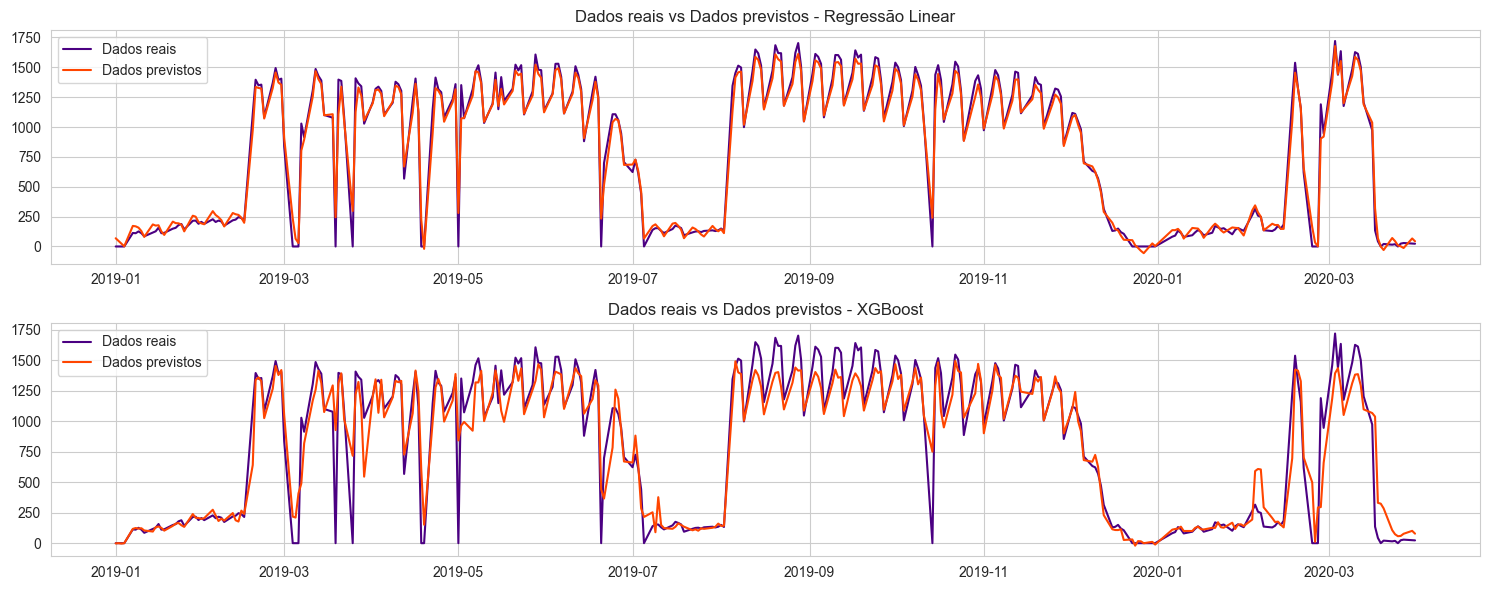

In [91]:
fig, ax = plt.subplots(2, 1, figsize = (15, 6))

sns.lineplot(y_test, 
             color='indigo', 
             label = 'Dados reais',
             ax = ax[0]).set(xlabel=None, ylabel=None)

sns.lineplot(y_pred_lr, 
             color='orangered', 
             label = 'Dados previstos',
             ax = ax[0]).set(xlabel=None, ylabel=None)

ax[0].set_title('Dados reais vs Dados previstos - Regressão Linear')

sns.lineplot(y_test, 
             color='indigo',
             label = 'Dados reais',
             ax = ax[1]).set(xlabel=None, ylabel=None)

sns.lineplot(y_pred_xgb, 
             color='orangered', 
             label = 'Dados previstos', 
             ax = ax[1]).set(xlabel=None, ylabel=None)

ax[1].set_title('Dados reais vs Dados previstos - XGBoost')

plt.legend()

fig.tight_layout()

Verificamos tanto através das métricas quanto visualmente que, para este problema, a Regressão Linear apresentou um resultado melhor que o XGBoost, então seguiremos com ela.

In [93]:
# exportando o modelo treinado

filename = 'finalized_model.sav'
MODEL_DIR = ROOT_DIR + '\webapp\\' + filename

pickle.dump(lr, open(MODEL_DIR, 'wb'))

## Etapa 5 - Interpret/Interpretação